In [15]:
import sys
from pathlib import Path
sys.path.append("..")
import pandas as pd
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from simulation.rotor import MagneticBearing3D
from simulation.pid import PID
from simulation.seal import Seal
from simulation.excitation_signals import *
from simulation.generate_dataset import *

In [16]:
import os

data_dir = Path("../simulation/data/")

data = []
for file in filter(lambda x: x.endswith(".csv"), os.listdir(data_dir)):
    data.append(pd.read_csv(data_dir / Path(file)))

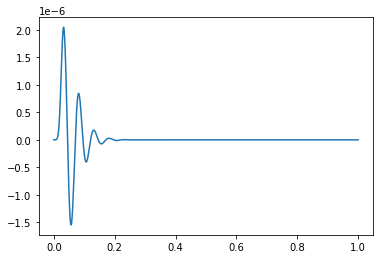

In [19]:
df = data[0]

plt.plot(df["t"], df["ay"])